# SNR does not cause sparse cell misses

author: steeve.laquitaine@epfl.ch


* `534` near-contact cells
* `472` pyramidal cells


## Setup

In [128]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image
import pandas as pd
import spikeinterface.qualitymetrics as quality
import seaborn as sns
from scipy.stats import spearmanr

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config, write_metadata
from src.nodes.dataeng.silico import probe_wiring
from src.nodes.io.silico.loading import load_campaign_params
from src.nodes.prepro import preprocess
from src.nodes.truth.silico import ground_truth
from src.pipes.sorting import match_sorted_to_true_neuropixels_2023_02_19 as match
from src.nodes.postpro import waveform, feateng
from src.nodes.postpro.missed_cells import get_missed_vs_detected
from src.nodes.postpro.cell_matching import match_true_and_sorter_cell_firing_rate as match_fr

# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"    # specifies the experiment 
SIMULATION_DATE = "2023_02_19"       # specifies the run (date)
MS_BEFORE = 3       # ms
MS_AFTER = 3        # ms

# SETUP CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SETUP PATH
SPIKE_FILE_PATH = data_conf["dataeng"]["campaign"]["output"]["spike_file_path"]
RAW_LFP_TRACE_FILE_PATH = data_conf["dataeng"]["campaign"]["output"]["trace_file_path"]
CELL_TRACE_FILE_PATH = data_conf["dataeng"]["campaign"]["output"]["unit_trace_path"]+"cell_3754013_trace.pkl"
CELL_MATCHING_PATH = data_conf["postprocessing"]["cell_matching"]


# SET WAVEFORM FOLDER
STUDY_FOLDER = data_conf["postprocessing"]["waveform"]["study"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-04-28 10:42:50,944 - root - utils.py - get_config - INFO - Reading experiment config.
2023-04-28 10:42:51,086 - root - utils.py - get_config - INFO - Reading experiment config. - done


# Signal-to-noise ratio

Limitations: this metrics calculation uses median absolute deviation in the denominator, which is less sensitive to outlier voltages caused by spikes than the standard deviation but is still sensitive to outliers when firing rate is high.

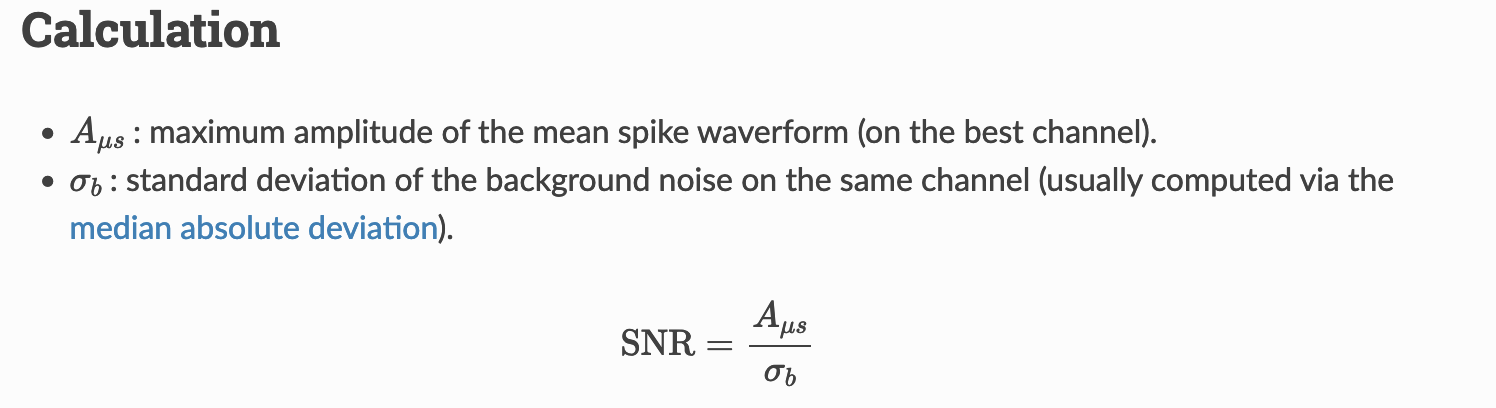

In [2]:
# report snr calculation
Image(filename="notebooks/1_results/assets/snr.png")

## Plot signal-to-noise ratio (SNR)

1. We preprocess the raw LFP traces
2. We extract the waveforms within -3 to 3 ms centered on the spike timestamps of the most active pyramidal to have a large enough spike sample size.
3. We plot the spike-triggered average of each contact
4. We plot the neuron and contact locations associated with each spike triggered average

TODO:
- spike location conversion takes lots of time. Solve or parallelize.

In [3]:
# load recording
recording = preprocess.load(data_conf=data_conf)

# load waveform extractor (a "study" must have been created with waveform.run() pipeline)
WaveformExtractor = waveform.load(recording, study_folder=STUDY_FOLDER)

In [4]:
# calculate snrs, dict of cell_id:snr ({19690: 29.467033, 24768: 92.0003 ...)
SNRs = quality.compute_snrs(WaveformExtractor)

In [5]:
# create Matching object (30 secs, 534 cells, 1 sorter)
out = match.run()

2023-04-28 09:44:17,886 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor
2023-04-28 09:44:17,932 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor - done: 0.0
2023-04-28 09:44:17,934 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor
2023-04-28 09:44:17,961 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor - done: 0.0
2023-04-28 09:44:36,659 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell oversplit - done
2023-04-28 09:44:36,666 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell misses - done


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/match_sorted_to_true_neuropixels_2023_02_19.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit_true_cell"].iloc[oversplit.index] = True


In [6]:
# load Matching objects and add features
cell_matching = pd.read_parquet(CELL_MATCHING_PATH)

# add SNR feature
cell_matching = feateng.add_true_snr(cell_matching, data_conf=data_conf)

# add firing rates
cell_matching = match_fr(data_conf, no_plot=True)

# label missed and detected cells
cell_matching = feateng.add_is_missed(cell_matching, data_conf)

# add true cells' signal-to-noise ratio
cell_matching = feateng.add_true_snr(cell_matching, data_conf)

2023-04-28 09:44:41,060 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor
2023-04-28 09:44:41,073 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor - done: 0.0
2023-04-28 09:44:41,074 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor
2023-04-28 09:44:41,085 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor - done: 0.0
2023-04-28 09:44:51,837 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell oversplit - done
2023-04-28 09:44:51,844 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell misses - done
2023-04-28 09:44:51,962 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor
2023-04-28 09:44:51,988 - root - match_sorted_to_true_

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/match_sorted_to_true_neuropixels_2023_02_19.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit_true_cell"].iloc[oversplit.index] = True


2023-04-28 09:45:02,737 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell oversplit - done
2023-04-28 09:45:02,743 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell misses - done


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/match_sorted_to_true_neuropixels_2023_02_19.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit_true_cell"].iloc[oversplit.index] = True


In [7]:
# sanity check
def test_matching(SNRs:dict, cell_matching:pd.DataFrame):

    # format and sort raw snrs
    snrs = pd.DataFrame.from_dict(SNRs, orient="index")
    snrs = snrs.reset_index().rename(columns={"index": "true_cell_match", 0:"snr"}).sort_index()
    snrs = snrs.sort_index()

    # sort processed snrs
    snrs_processed = cell_matching[["true_cell_match", "snr"]].drop_duplicates(subset=['true_cell_match'])
    snrs_processed = snrs_processed.sort_values(by="true_cell_match")
    snrs_processed = snrs_processed.reset_index()

    assert snrs_processed["snr"].equals(snrs["snr"]), "the processed snrs do not match the raw snrs, matching failed."

test_matching(SNRs, cell_matching)

In [133]:
def plot_pmiss_by_feature(cell_matching:pd.DataFrame, feature:str, n_bin:int, xlabel:str):

    # plot probability of misses by feature bins

    # - sort by snr
    df = cell_matching.sort_values(by=feature)
    df = df.drop_duplicates(subset=['true_cell_match'])

    # - vectorize "detection_label" feature
    detected = df["detection_label"] == "missed"
    detected = detected.astype(int)

    # - get snr feature
    snr = df[feature]

    # get bins
    # round max snr to the nearest 10
    max_snr = df[feature].max()
    # max_snr = np.ceil(round(df[feature].max()) / 10) * 10
    bin_size = max_snr/n_bin
    bins = np.arange(0, max_snr + bin_size, bin_size)

    # get snr bin indices
    df_cut = pd.cut(df[feature],  bins=bins, labels=bins[1:], retbins=True)
    misses_by_snr = pd.DataFrame(data={feature: df_cut[0], "detection_label": detected})

    # calculate p(misses) and its variance by snr
    pmisses_by_snr = misses_by_snr.groupby(feature).mean()
    varmisses_by_snr = misses_by_snr.groupby(feature).sem()

    # plot errorbar
    _, axes = plt.subplots(1,3,figsize=(13,2), gridspec_kw={'width_ratios': [2, 6, 6]})

    # snr stats by detection status
    mean_snr_by_detection_label = df[["detection_label",feature]].groupby("detection_label").mean()
    sem_snr_by_detection_label = df[["detection_label",feature]].groupby("detection_label").sem()

    # plot
    axes[0].bar(
        x=["detected", "missed"], height=mean_snr_by_detection_label[feature].values, yerr=sem_snr_by_detection_label[feature].values,
        facecolor=(0.9,0.9,0.9), edgecolor="w"
        )

    # set legend
    axes[0].set_xlabel("true cell status", fontsize=9);
    axes[0].set_ylabel(xlabel, fontsize=9);
    axes[0].set_xticklabels(["detected","missed"], fontsize=9);
    axes[0].spines[['right', 'top']].set_visible(False)

    # plot
    axes[1].hist(df[df["detection_label"]=="missed"][feature], bins=bins, color=(0.3, 0.3, 0.3), edgecolor="w")
    axes[1].hist(df[df["detection_label"]=="detected"][feature], bins=bins, color="w", edgecolor=(0.3, 0.3, 0.3),rwidth=0.8)

    # set legend
    axes[1].set_xlabel(xlabel, fontsize=9);
    axes[1].set_ylabel("cell count (log-scale)", fontsize=9);
    axes[1].spines[['right', 'top']].set_visible(False)
    axes[1].legend(["missed", "detected"], fontsize=9, frameon=False)    
    axes[1].set_yscale('log')

    # plot miss ratios by snr
    axes[2].errorbar(x=list(
        pmisses_by_snr.index), y=pmisses_by_snr["detection_label"].values.tolist(), yerr=varmisses_by_snr["detection_label"].values.tolist(),
        marker="o", markersize=8, markeredgecolor="w", markerfacecolor=(0.4,0.4,0.4), ecolor=(0.8,0.8,0.8), color=(0.3,0.3,0.3)
        );
    axes[2].hlines(xmin=0, xmax=max_snr, y=0.5, color=(0.8,0.8,0.8), linestyle="--")

    # set legend
    axes[2].set_ylim([-0.03, 1.03]);
    axes[2].set_ylabel("miss ratio",fontsize=9);
    axes[2].set_xlabel(xlabel,fontsize=9);
    axes[2].spines[['right', 'top']].set_visible(False)
    axes[2].legend(["chance", "data"], fontsize=9, frameon=False)    

coef: -0.23557430399669707 ; p: 3.614681580606646e-08


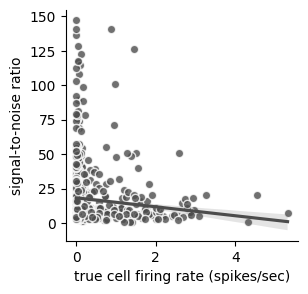

In [132]:
# snr's effect on pmiss must be disambiguated from firing rate's effect as they are correlated
df = cell_matching.drop_duplicates(subset=['true_cell_match'])

fig, ax = plt.subplots(1,1,figsize=(3,3))
sns.regplot(ax=ax, x=df["true firing rate"].values, y=df["snr"].values, ci=95, robust=True, color=(.3,.3,.3), scatter_kws={"edgecolor":"w"});
ax.spines[['right', 'top']].set_visible(False);
ax.set_xlabel("true cell firing rate (spikes/sec)");
ax.set_ylabel("signal-to-noise ratio");
np.corrcoef(df["true firing rate"], df["snr"])

# non-parametric spearman rank correlation
coef, p = spearmanr(df["true firing rate"], df["snr"])
print("coef:", coef, "; p:", p)

/tmp/ipykernel_165678/3708526888.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(["detected","missed"], fontsize=9);
/tmp/ipykernel_165678/3708526888.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(["detected","missed"], fontsize=9);


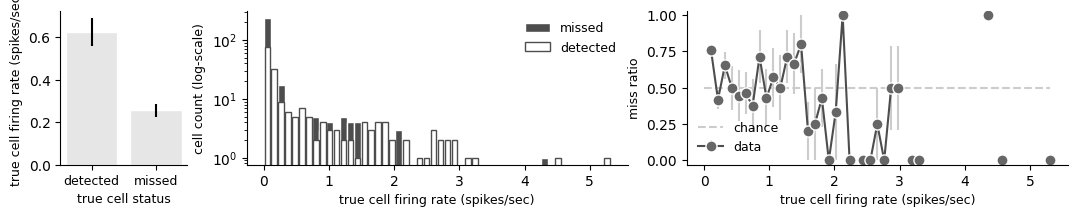

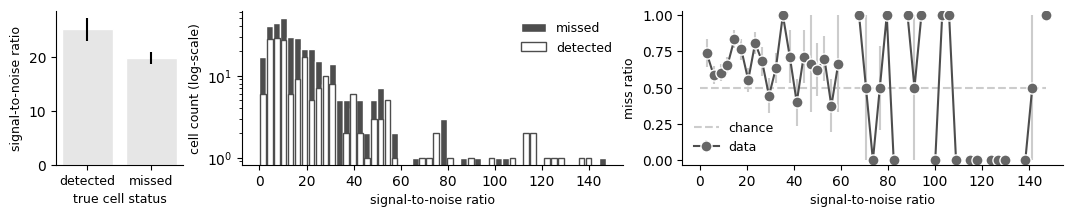

In [134]:
# plot pmiss by features
N_BINS = 50

plot_pmiss_by_feature(cell_matching, "true firing rate", n_bin=N_BINS, xlabel="true cell firing rate (spikes/sec)")
plot_pmiss_by_feature(cell_matching, "snr", n_bin=N_BINS, xlabel="signal-to-noise ratio")